In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt, timedelta
from matplotlib.dates import MonthLocator, DateFormatter

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes/table names that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Create the inspector and connect it to the engine 
inspector = inspect(engine) 

In [8]:
#Print/Inspect column names for station table 
stationcolumns = inspector.get_columns('station')
for column in stationcolumns: 
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
#Print/Inspect column names for measurement table 
measurementcolumns = inspector.get_columns('measurement')
for column in measurementcolumns: 
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(func.max((measurement.date))).scalar()
print(recent_date)

2017-08-23


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Create a variable for the recent_date 
most_recent_date = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
date_between = most_recent_date - dt.timedelta(days=365)
                        
# Perform a query to retrieve the data and precipitation scores
one_year = session.query(measurement.date, measurement.prcp).filter(measurement.date >= date_between).all() 
    
# Ceate a pandas dataframe  
one_year_df = pd.DataFrame(one_year, columns = ['Date','Precipitation'])

# Sort the dataframe by date
one_year_df = one_year_df.sort_values(by='Date')
one_year_df.head()

Date  Precipitation
0     2016-08-23            0.0
1009  2016-08-23            NaN
1529  2016-08-23           45.5
704   2016-08-23            1.3
361   2016-08-23            3.8

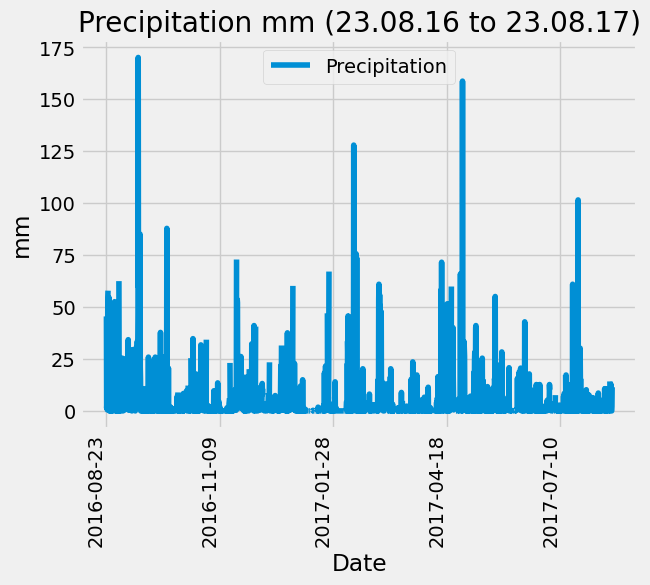

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
one_year_df.plot(y='Precipitation', x='Date', xlabel='Date', ylabel='mm', title = "Precipitation mm (23.08.16 to 23.08.17)")
plt.xticks(rotation = 90, horizontalalignment ='right')
plt.savefig('Output/fig1.png')
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_stats = pd.DataFrame(one_year_df['Precipitation'].describe())
prcp_stats

Precipitation
count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000

# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(measurement.station).distinct().count()
print(station_count)

9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

lowest_temperature = session.query(func.min(measurement.tobs)).filter(measurement.station == most_active_station).scalar()
highest_temperature = session.query(func.max(measurement.tobs)).filter(measurement.station == most_active_station).scalar()
average_temperature = session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active_station).scalar()

print(f"The lowest temperature is {lowest_temperature}")
print(f"The highest temperature is {highest_temperature}")
print(f"The average temperature is {round(average_temperature,1)}")

The lowest temperature is 12.2
The highest temperature is 29.4
The average temperature is 22.0


In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
one_year_temp = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date >= date_between).\
    filter(measurement.station == most_active_station).all() 

one_year_temp_df = pd.DataFrame(one_year_temp, columns = ['Date','TOBS'])

one_year_temp_df = (one_year_temp_df.sort_values(by='Date')).set_index('Date')
one_year_temp_df.head()

TOBS
Date            
2016-08-23  25.0
2016-08-24  25.0
2016-08-25  26.7
2016-08-26  26.7
2016-08-27  23.9

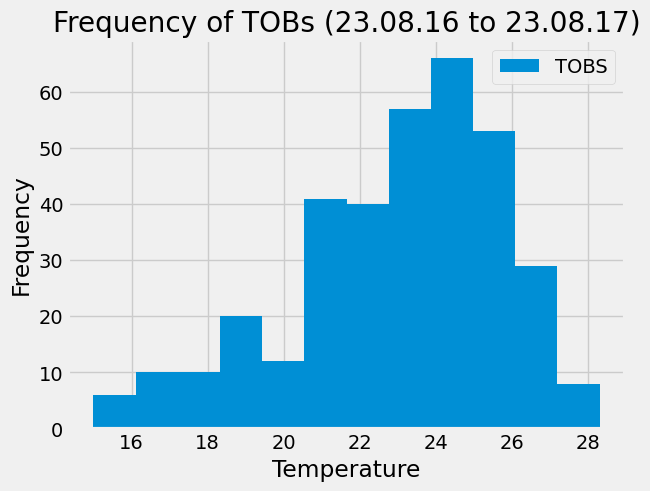

In [20]:
#Plot the results as a histogram
one_year_temp_df.plot.hist(bins = 12, title= "Frequency of TOBs (23.08.16 to 23.08.17)", xlabel= "Temperature")
plt.savefig('Output/fig2.png')
plt.show()

# Close Session

In [21]:
# Close Session
session.close()